In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
import pdb
sns.set()

Import relevant data from KQ4 spreadsheet.

In [2]:
keep_columns = ['Author', 'Year', 'Refid', 'Pre-op', 'Initial Surgery', 'Morcellation',
       'Power', 'Upstaged', 'Months follow-up',
       'Median_\nFUP_time', 'Range_\nFUP_Time', 'Outcome', 'Age',
       'Menopausal Status', 'Lost_to_Fup', 'Include', 'Inclusion staging criteria restricted or not (y/n)']

kq4_data = (pd.read_excel('data/UF_KQ4_data_for_Chris_12142016_SK.xlsx', sheetname='All_KQ4_data_Original', 
                         na_values=['NR', 'NA'])[keep_columns]
                .rename(columns={'Months follow-up': 'fup_months',
                               'Median_\nFUP_time': 'fup_median', 
                               'Range_\nFUP_Time': 'fup_range',
                                'Pre-op': 'preop', 
                                 'Initial Surgery': 'surgery_init',
                                'Menopausal Status': 'menop_status',
                                'Inclusion staging criteria restricted or not (y/n)': 'stage_include'}))

kq4_data.columns = kq4_data.columns.str.lower()

Drop excludes (rows colored yellow in the spreadsheet, or those with "lost_to_fup" values instead of censoring time).

In [3]:
kq4_data = kq4_data[(kq4_data.include==1) & (kq4_data.lost_to_fup!='yes')].drop(['include', 'lost_to_fup'], axis=1)

In [4]:
kq4_data.head()

,author,year,refid,preop,surgery_init,morcellation,power,upstaged,fup_months,fup_median,fup_range,outcome,age,menop_status,stage_include
0,Einstein,2008.0,405,Benign,LSC SCH,Yes,Yes,No,30.0,NaN,NaN,NED,NaN,NaN,No
1,Einstein,2008.0,405,Benign,LMYOM,Yes,Yes,Yes,61.0,NaN,NaN,NED,NaN,NaN,No
2,Einstein,2008.0,405,Benign,SCH,Yes,No,Yes,31.0,NaN,NaN,AWD,NaN,NaN,No
3,Einstein,2008.0,405,Benign,SCH BSO,No,No,No,37.0,NaN,NaN,NED,NaN,NaN,No
4,Einstein,2008.0,405,Benign,SCH BSO,No,No,Yes,6.0,NaN,NaN,AWD,NaN,NaN,No


In [5]:
stage1_only = False
    
if stage1_only:
    kq4_data = kq4_data[kq4_data.stage_include=='Yes']

Drop those with missing `power` or `morcellation` covariates. Perhaps we can impute later.

In [6]:
kq4_data = kq4_data.dropna(subset=['morcellation', 'power']).reset_index(drop=True)

Values are a mess in several columns:

In [7]:
kq4_data.outcome.value_counts()

Alive    171
Dead      62
alive     52
dead      48
AWD       30
NED       29
Died      22
Name: outcome, dtype: int64

In [8]:
kq4_data['preop'].value_counts()

benign     204
Benign     169
sarcoma      3
Benign       1
Name: preop, dtype: int64

In [9]:
kq4_data.outcome = kq4_data.outcome.replace({'Alive': 'alive',
                         'Dead': 'dead',
                         'AWD': 'awd',
                         'NED': 'ned',
                         'Died': 'dead'})
kq4_data.outcome.value_counts()

alive    223
dead     132
awd       30
ned       29
Name: outcome, dtype: int64

In [10]:
kq4_data.preop = kq4_data.preop.str.strip().replace({'Benign': 'benign'})
kq4_data['preop'].value_counts()

benign     374
sarcoma      3
Name: preop, dtype: int64

This is also a mess. Need to fix.

In [11]:
pd.crosstab(kq4_data.morcellation, kq4_data.power)

power,No,Yes,no,yes
morcellation,,,,
No,261,0,0,0
Yes,38,44,24,0
no,0,0,5,0
yes,13,0,4,25


In [12]:
kq4_data.morcellation = kq4_data.morcellation.str.lower()
kq4_data.power = kq4_data.power.str.lower()

pd.crosstab(kq4_data.morcellation, kq4_data.power)

power,no,yes
morcellation,,
no,266,0
yes,79,69


Create death outcome column

In [13]:
kq4_data['died'] = (kq4_data.outcome=='dead').astype(int)
kq4_data.died.value_counts()

0    282
1    132
Name: died, dtype: int64

In [14]:
kq4_data.head(20)

,author,year,refid,preop,surgery_init,morcellation,power,upstaged,fup_months,fup_median,fup_range,outcome,age,menop_status,stage_include,died
0,Einstein,2008.0,405,benign,LSC SCH,yes,yes,No,30.0,NaN,NaN,ned,NaN,NaN,No,0
1,Einstein,2008.0,405,benign,LMYOM,yes,yes,Yes,61.0,NaN,NaN,ned,NaN,NaN,No,0
2,Einstein,2008.0,405,benign,SCH,yes,no,Yes,31.0,NaN,NaN,awd,NaN,NaN,No,0
3,Einstein,2008.0,405,benign,SCH BSO,no,no,No,37.0,NaN,NaN,ned,NaN,NaN,No,0
4,Einstein,2008.0,405,benign,SCH BSO,no,no,Yes,6.0,NaN,NaN,awd,NaN,NaN,No,0
5,Kamikabeya,2010.0,753,benign,TAH BSO,no,no,No,2.0,NaN,NaN,dead,58.0,Post,No,1
6,Takamizawa,1999.0,750,benign,TAH,no,no,NaN,132.0,NaN,NaN,ned,44.0,NaN,NaN,0
7,Oduyebo,2014.0,145,benign,LSC SCH,yes,yes,No,27.0,NaN,NaN,ned,NaN,NaN,No,0
8,Oduyebo,2014.0,145,benign,LSC SCH,yes,yes,No,38.0,NaN,NaN,ned,NaN,NaN,No,0
9,Oduyebo,2014.0,145,benign,LMYOM,yes,yes,No,48.7,NaN,NaN,ned,NaN,NaN,No,0


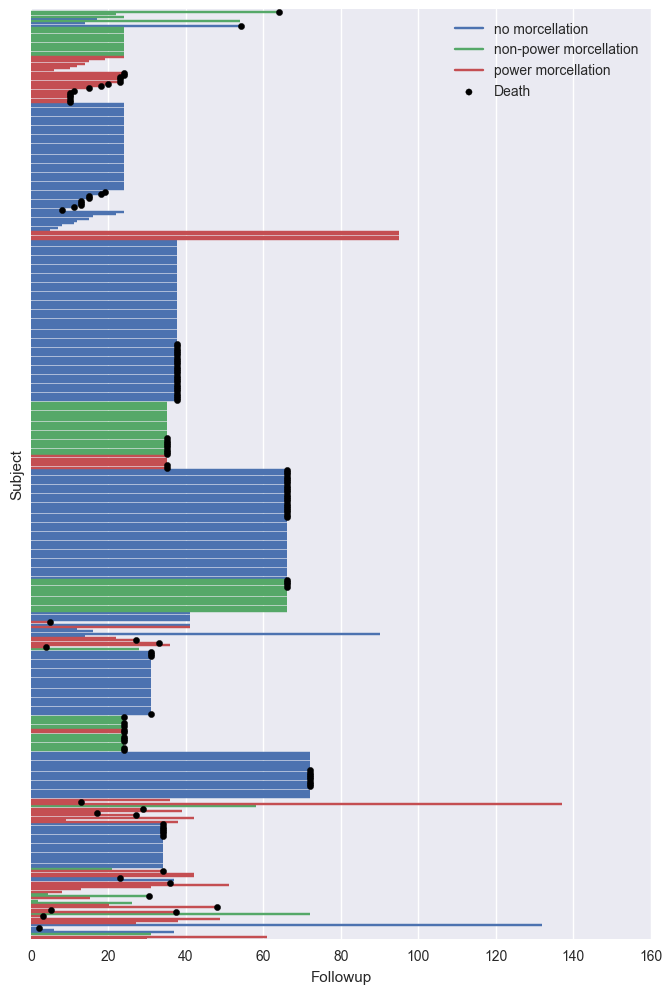

In [15]:
fig, ax = plt.subplots(figsize=(8, 12))
n_patients = kq4_data.shape[0]

time = kq4_data.fup_months

ix0 = kq4_data.morcellation=='no'
ix1 = (kq4_data.morcellation=='yes') & (kq4_data.power=='no')
ix2 = (kq4_data.morcellation=='yes') & (kq4_data.power=='yes')

blue, green, red = sns.color_palette()[:3]

ax.hlines(kq4_data.index[ix0], 0, time[ix0],
          color=blue, label='no morcellation')

ax.hlines(kq4_data.index[ix1], 0, time[ix1],
          color=green, label='non-power morcellation')

ax.hlines(kq4_data.index[ix2], 0, time[ix2],
          color=red, label='power morcellation')

ax.scatter(time[kq4_data.died == 1], kq4_data.index[kq4_data.died == 1],
           color='k', zorder=10, label='Death');

ax.set_xlim(left=0)
ax.set_ylabel('Subject')
ax.set_xlabel('Followup')
ax.set_yticks([])

ax.set_ylim(-0.25, n_patients + 0.25)

ax.legend(loc='upper right');

In [16]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

In [17]:
kmf.fit(kq4_data.fup_months, event_observed=kq4_data.died)

<lifelines.KaplanMeierFitter: fitted with 414 observations, 282 censored>

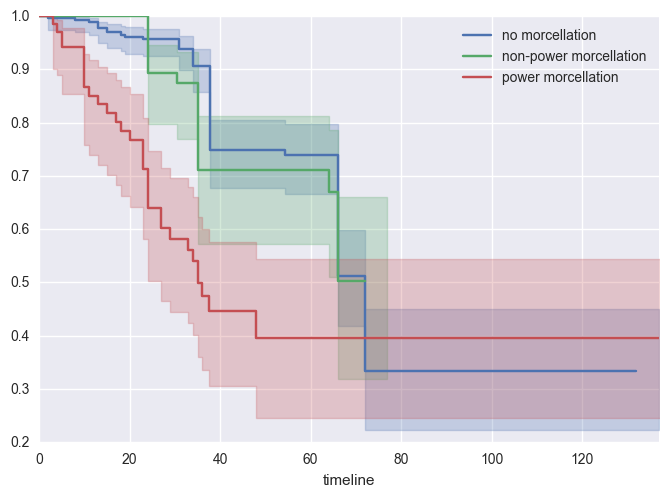

In [18]:
time = kq4_data.fup_months
event = event_observed=kq4_data.died
ix0 = kq4_data.morcellation=='no'
ix1 = (kq4_data.morcellation=='yes') & (kq4_data.power=='no')
ix2 = (kq4_data.morcellation=='yes') & (kq4_data.power=='yes')



kmf.fit(time[ix0], event[ix0], label='no morcellation')
ax = kmf.plot()

kmf.fit(time[ix1], event[ix1], label='non-power morcellation')
kmf.plot(ax=ax)

kmf.fit(time[ix2], event[ix2], label='power morcellation')
kmf.plot(ax=ax)

Some studies show event time truncated to the end of the followup period. These values should be treated as **missing** and their values imputed from the range of possible followup times.

In [19]:
kq4_data.loc[kq4_data.fup_median.notnull(), 'fup_months'] = np.nan

In [20]:
kq4_data['fup_min'] = 0
kq4_data['fup_max'] = kq4_data.fup_months.max()

fup_min, fup_max = np.transpose([[float(x[0]), float(x[1])] for x in kq4_data.fup_range[kq4_data.fup_median.notnull()].str.split('-')])

If the event was a death event, make the `fup_min` equal to zero.

In [21]:
kq4_data.loc[kq4_data.fup_median.notnull(), 'fup_min'] = fup_min * ((1-kq4_data.died)[kq4_data.fup_median.notnull()])
kq4_data.loc[kq4_data.fup_median.notnull(), 'fup_max'] = fup_max

Summarize proportion of missing values

In [22]:
kq4_data.isnull().mean().round(2)

author           0.00
year             0.00
refid            0.00
preop            0.09
surgery_init     0.00
morcellation     0.00
power            0.00
upstaged         0.67
fup_months       0.62
fup_median       0.38
fup_range        0.36
outcome          0.00
age              0.53
menop_status     0.79
stage_include    0.02
died             0.00
fup_min          0.00
fup_max          0.00
dtype: float64

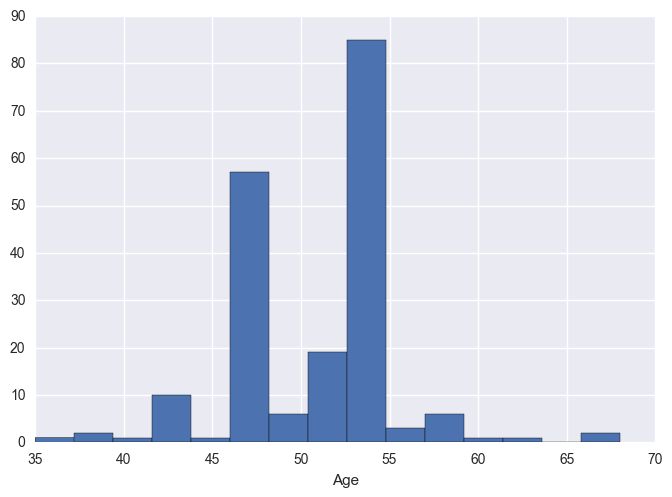

In [23]:
axes = kq4_data.age.hist(bins=15)
axes.set_xlabel('Age')

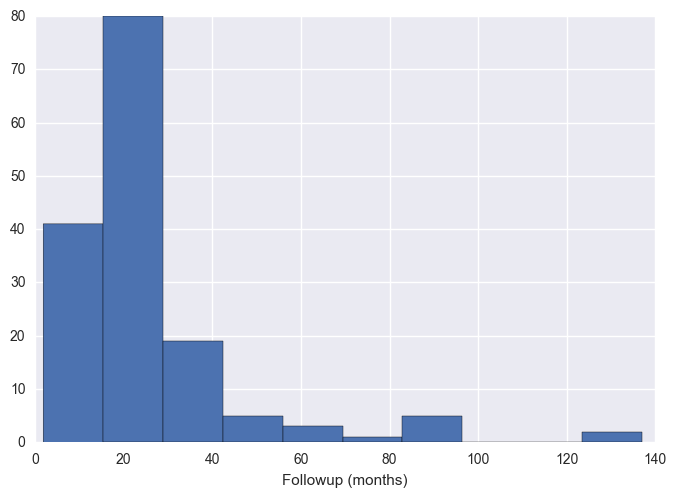

In [24]:
axes = kq4_data['fup_months'].hist()
axes.set_xlabel('Followup (months)')

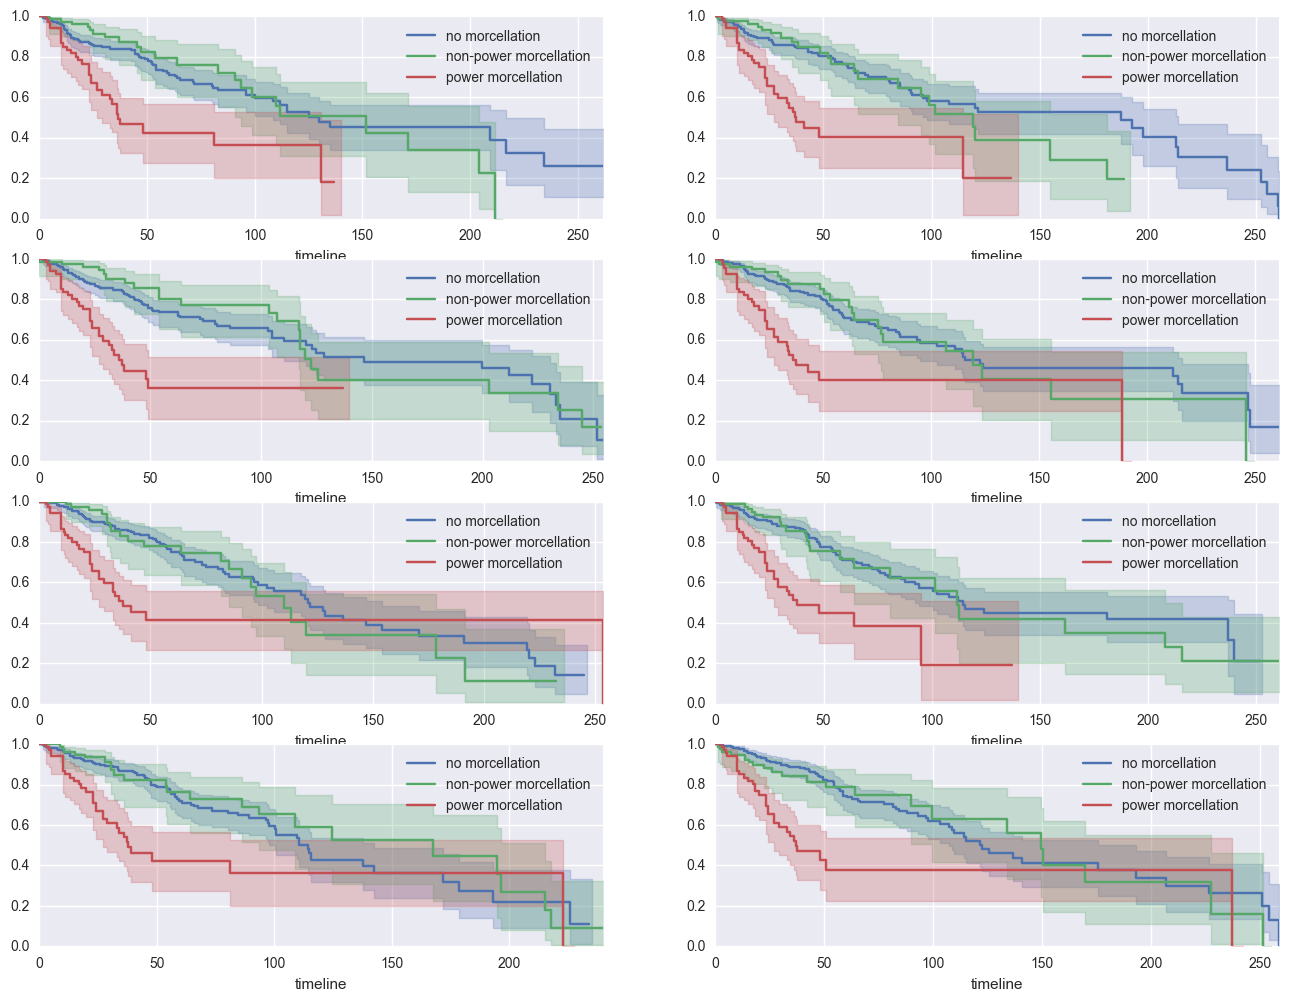

In [25]:
fig, axes = plt.subplots(4,2,figsize=(16,12))

for ax in axes.flatten():
    
    time_sim = kq4_data.fup_months.copy()
    event = event_observed=kq4_data.died
    missing_times = kq4_data.fup_months.isnull()
    time_sim.loc[missing_times] = np.random.uniform(kq4_data.fup_min[missing_times], 
                                                    kq4_data.fup_max[missing_times])
    
    ix0 = kq4_data.morcellation=='no'
    ix1 = (kq4_data.morcellation=='yes') & (kq4_data.power=='no')
    ix2 = (kq4_data.morcellation=='yes') & (kq4_data.power=='yes')

    kmf = KaplanMeierFitter()
    kmf.fit(time_sim[ix0], event[ix0], label='no morcellation')
    kmf.plot(ax=ax)

    kmf.fit(time_sim[ix1], event[ix1], label='non-power morcellation')
    kmf.plot(ax=ax)

    kmf.fit(time_sim[ix2], event[ix2], label='power morcellation')
    kmf.plot(ax=ax)

In [26]:
model_data = (kq4_data.assign(non_power_morcellation=(kq4_data.morcellation=='yes') & (kq4_data.power=='no'))
                      .assign(power_morcellation=(kq4_data.morcellation=='yes') & (kq4_data.power=='yes')))

In [27]:
time = model_data['fup_months']
event = event_observed = model_data.died.astype(int)
n_intervals = int(time.max()+1)
n_patients = model_data.shape[0]

In [28]:
time_missing = model_data['fup_months'].copy()
time_missing[time_missing.isnull()] = 1
time_masked = np.ma.masked_values(time_missing, value=1)

#non_power, power = model_data[['non_power_morcellation', 'power_morcellation']].values.astype(int).T
power = (model_data.power=='yes').astype(int)
morcellation = (model_data.morcellation=='yes').astype(int)

In [29]:
fup_min, fup_max = model_data[['fup_min', 'fup_max']].T.values

In [30]:
from pymc3 import Normal, Deterministic, sample, NUTS, Model, DensityDist, Metropolis, Potential, Exponential, Uniform
from pymc3 import traceplot, forestplot, summary, sample_ppc
import theano.tensor as tt

In [31]:
with Model() as exp_model:

    # Linear model parameters
    β = Normal('β', mu=0.0, tau=0.0001, shape=3)

    # Survival rates
    λ = Deterministic('λ', tt.exp(β[0] + β[1] * morcellation + β[2] * power))
    
    # Impute missing event times
#     time_imputed = Exponential('time_imputed', lam=λ, observed=time_masked)
    time_imputed = Uniform('time_imputed', lower=fup_min, upper=fup_max, observed=time_masked)
    
    # Impose bound on missing times
    fup_bound = Potential('fup_bound', Uniform.dist(lower=fup_min, upper=fup_max).logp(time_imputed))

    # Exponential survival likelihood, accounting for censoring
    def logp(event):
        return event * tt.log(λ) - λ * time_imputed

    survival = DensityDist('survival', logp, observed={'event':event})


In [32]:
n_iterations = 20000
n_burn = 10000

In [33]:
with exp_model:
    start = {'time_imputed_missing': np.random.uniform((model_data.fup_min)[model_data.fup_months.isnull()],
                                                      (model_data.fup_max)[model_data.fup_months.isnull()])}
    exp_trace = sample(n_iterations, step=Metropolis(), start=start)

100%|██████████| 20000/20000 [00:05<00:00, 3560.33it/s]


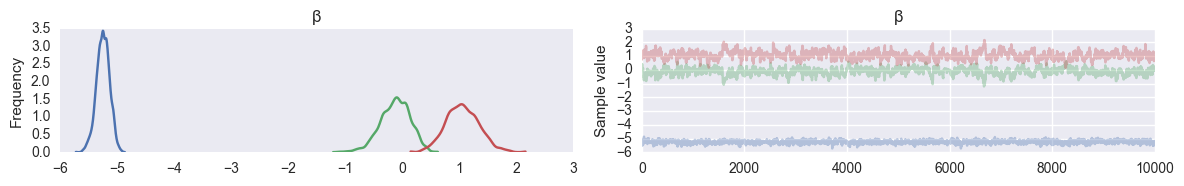

In [34]:
traceplot(exp_trace[n_burn:], varnames=['β']);

In [35]:
summary(exp_trace[n_burn:], varnames=['β'])


β:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -5.248           0.115            0.004            [-5.474, -5.020]
  -0.126           0.261            0.016            [-0.643, 0.347]
  1.060            0.290            0.017            [0.470, 1.593]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -5.494         -5.323         -5.246         -5.170         -5.030
  -0.679         -0.299         -0.111         0.058          0.326
  0.515          0.857          1.050          1.256          1.660



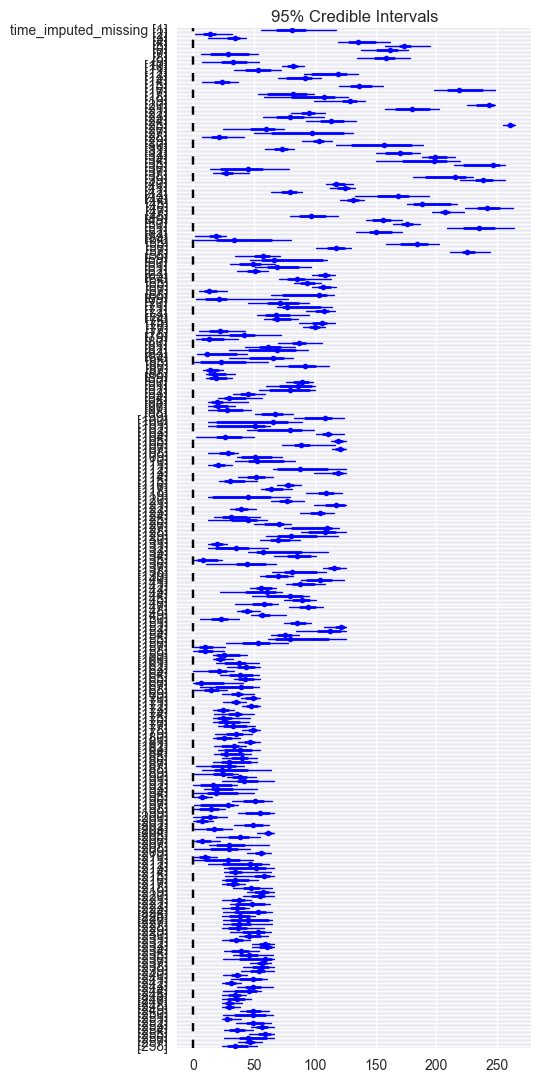

In [36]:
plt.figure(figsize=(6,12))
forestplot(exp_trace, varnames=['time_imputed_missing'])

In [37]:
baseline_hazard = np.exp(exp_trace['β'][n_burn:, 0])
non_power_hazard = np.exp(exp_trace['β'][n_burn:, 0] + exp_trace['β'][n_burn:, 1])
power_hazard = np.exp(exp_trace['β'][n_burn:, 0] + exp_trace['β'][n_burn:, 1] + exp_trace['β'][n_burn:, 2])

In [38]:
hazard_df = pd.DataFrame({'baseline':baseline_hazard, 'non-power':non_power_hazard, 'power':power_hazard})

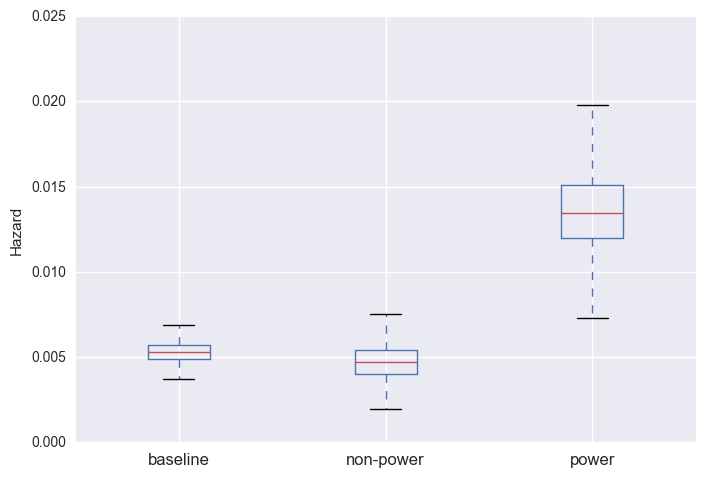

In [39]:
hazard_df.boxplot()
plt.ylabel('Hazard');

In [40]:
def cum_hazard(hazard, n=n_intervals):
    return (np.arange(n) * hazard.reshape(-1,1)).cumsum(axis=-1)

def survival(hazard):
    return np.exp(-cum_hazard(hazard))

In [41]:
def plot_with_hpd(x, hazard, f, ax, color=None, label=None, alpha=0.05, **kwargs):

    mean = f(hazard.mean(axis=0), **kwargs)
    
    percentiles = 100 * np.array([alpha / 2., 1. - alpha / 2.])
    hpd = np.percentile(f(hazard, **kwargs), percentiles, axis=0)
    
    ax.fill_between(x, hpd[0], hpd[1], color=color, alpha=0.25)
    ax.step(x, mean.squeeze(), color=color, label=label);

In [42]:
interval_bounds = np.arange(0, time.max() + 2, 1)

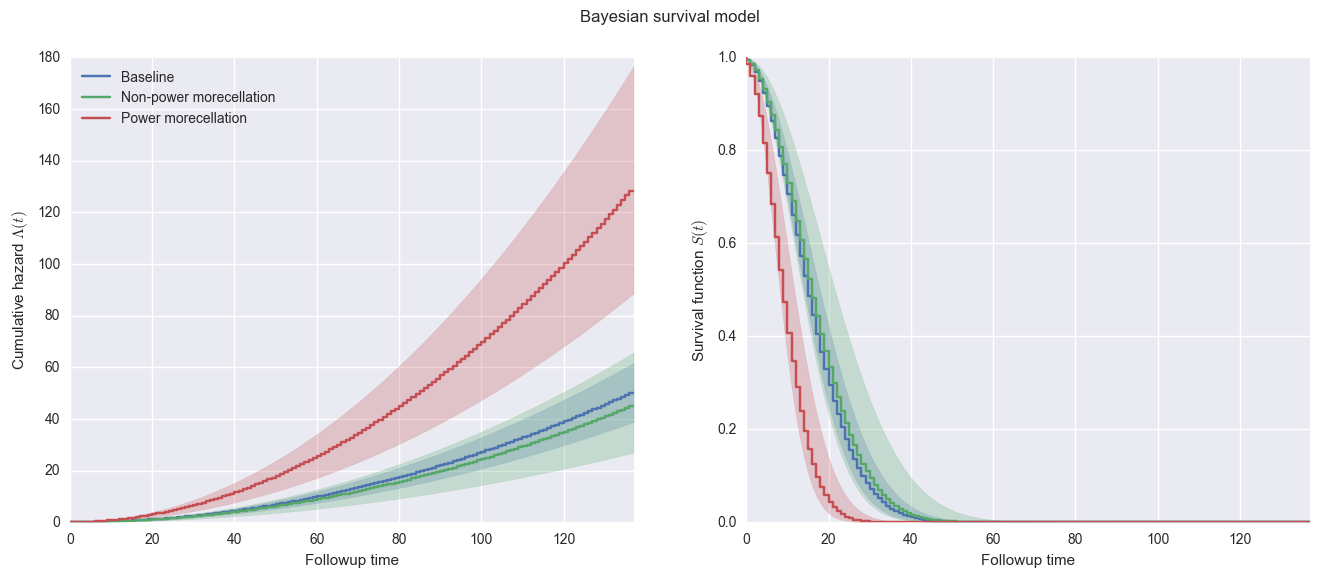

In [43]:
fig, (hazard_ax, surv_ax) = plt.subplots(ncols=2, sharex=True, sharey=False, figsize=(16, 6))

plot_with_hpd(interval_bounds[:-1], baseline_hazard, cum_hazard,
              hazard_ax, color=blue, label='Baseline')
plot_with_hpd(interval_bounds[:-1], non_power_hazard, cum_hazard,
              hazard_ax, color=green, label='Non-power morecellation')
plot_with_hpd(interval_bounds[:-1], power_hazard, cum_hazard,
              hazard_ax, color=red, label='Power morecellation')

hazard_ax.set_xlim(0, time.max());
hazard_ax.set_xlabel('Followup time');

hazard_ax.set_ylabel(r'Cumulative hazard $\Lambda(t)$');

hazard_ax.legend(loc=2);

plot_with_hpd(interval_bounds[:-1], baseline_hazard, survival,
              surv_ax, color=blue)
plot_with_hpd(interval_bounds[:-1], non_power_hazard, survival,
              surv_ax, color=green)
plot_with_hpd(interval_bounds[:-1], power_hazard, survival,
              surv_ax, color=red)

surv_ax.set_xlim(0, time.max());
surv_ax.set_xlabel('Followup time');

surv_ax.set_ylabel('Survival function $S(t)$');

fig.suptitle('Bayesian survival model');

Unfortunately, the exponential (*i.e.* constant hazard) model does not seem to fit the data, based on the comparison between the K-M curves and the survival function. 

Below, we try a Weibull model for the survival function.

## Weibull survival model

In [44]:
from pymc3 import Weibull

In [45]:
with Model() as weibull_model:

    # Linear model parameters
    β = Normal('β', mu=0.0, tau=0.0001, shape=3)

    # Survival rates
    k = Uniform('k', 0, 20)
    λ = Deterministic('λ', tt.exp(β[0] + β[1] * morcellation + β[2] * power))
    
    # Impute missing event times
#     time_imputed = Weibull('time_imputed', k, λ, observed=time_masked)
    time_imputed = Uniform('time_imputed', lower=fup_min, upper=fup_max, observed=time_masked)

    
    # Impose bound on missing times
    fup_bound = Potential('fup_bound', Uniform.dist(lower=fup_min, upper=fup_max).logp(time_imputed))

    # Exponential survival likelihood, accounting for censoring
    def logp(event):
        return event * (tt.log(k/λ) + (k-1)*tt.log(time_imputed/λ)) - (time_imputed/λ)**k

    survival = DensityDist('survival', logp, observed={'event':event})


In [46]:
with weibull_model:
    start = {'time_imputed_missing': np.random.uniform((model_data.fup_min)[model_data.fup_months.isnull()],
                                                      (model_data.fup_max)[model_data.fup_months.isnull()])}
    weibull_trace = sample(n_iterations, step=Metropolis(), start=start)

100%|██████████| 20000/20000 [00:08<00:00, 2348.92it/s]


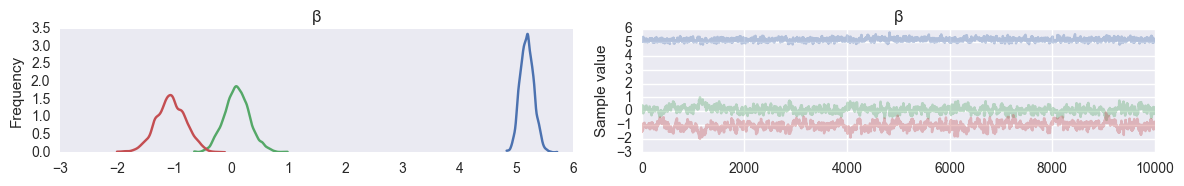

In [47]:
traceplot(weibull_trace[n_burn:], varnames=['β']);

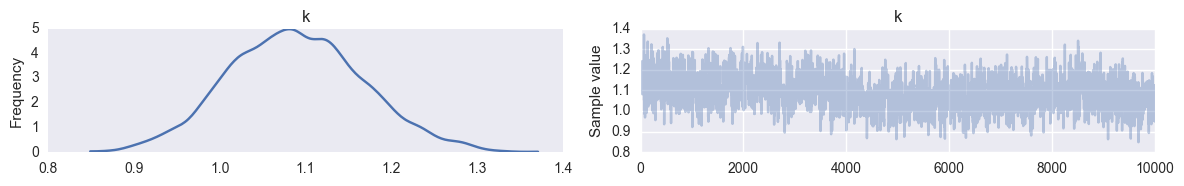

In [48]:
traceplot(weibull_trace[n_burn:], varnames=['k']);

In [49]:
hazard_df = pd.DataFrame({'baseline':baseline_hazard, 'non-power':non_power_hazard, 'power':power_hazard})

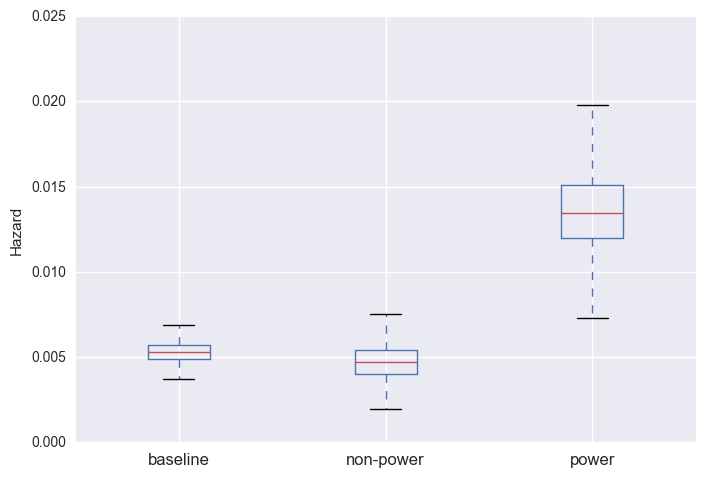

In [50]:
hazard_df.boxplot()
plt.ylabel('Hazard');

In [51]:
baseline_lam = np.exp(weibull_trace['β'][n_burn:, 0])
non_power_lam = np.exp(weibull_trace['β'][n_burn:, 0] + weibull_trace['β'][n_burn:, 1])
power_lam = np.exp(weibull_trace['β'][n_burn:, 0] + weibull_trace['β'][n_burn:, 1] + weibull_trace['β'][n_burn:, 2])
k_trace = weibull_trace['k'][n_burn:]

In [52]:
n_intervals = 250
interval_bounds = np.arange(0, n_intervals + 1, 1)

In [53]:
def cum_weibull_hazard(lam, k=k_trace, t=n_intervals):
    return (np.arange(t)/(lam.reshape(-1,1))**k.reshape(-1,1))

def weibull_survival(lam, k=k_trace, t=n_intervals):
    return np.exp(-cum_weibull_hazard(lam, k, t))

In [54]:
def plot_with_hpd(x, lam, f, ax, color=None, label=None, alpha=0.05, debug=False, **kwargs):

    m = f(lam, **kwargs).mean(axis=0)
    
    percentiles = 100 * np.array([alpha / 2., 1. - alpha / 2.])
    hpd = np.percentile(f(lam, **kwargs), percentiles, axis=0)
    
    if debug:
        import pdb;pdb.set_trace()
    ax.fill_between(x, hpd[0], hpd[1], color=color, alpha=0.25)
    ax.step(x, m, color=color, label=label);

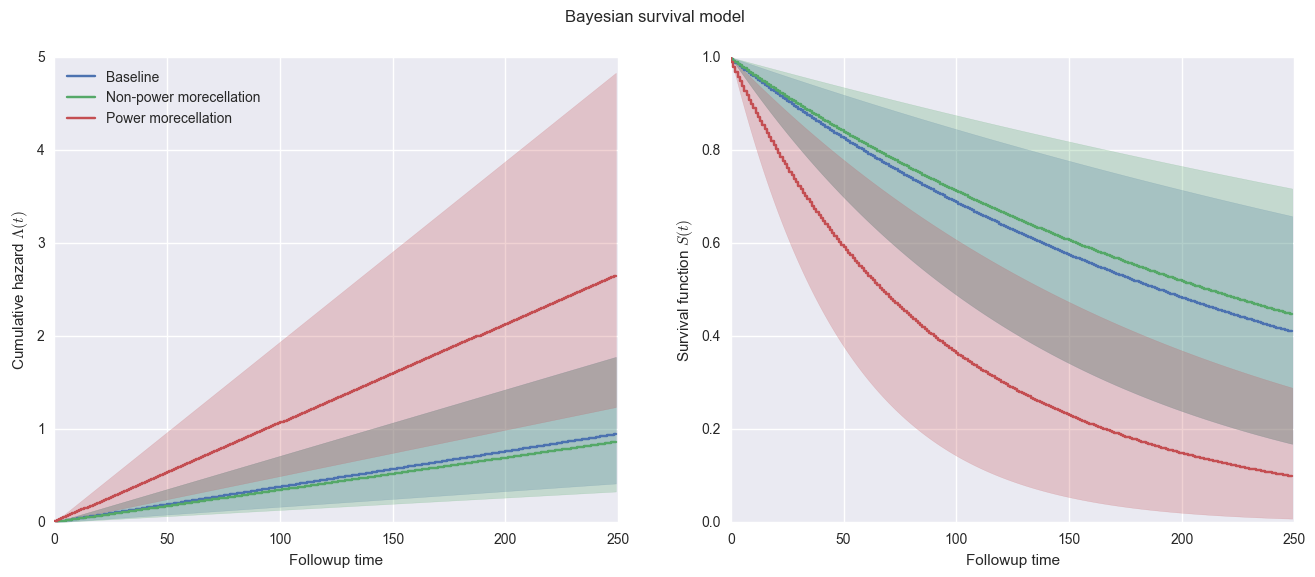

In [55]:
fig, (hazard_ax, surv_ax) = plt.subplots(ncols=2, sharex=True, sharey=False, figsize=(16, 6))

plot_with_hpd(interval_bounds[:-1], baseline_lam, cum_weibull_hazard,
              hazard_ax, color=blue, label='Baseline')
plot_with_hpd(interval_bounds[:-1], non_power_lam, cum_weibull_hazard,
              hazard_ax, color=green, label='Non-power morecellation')
plot_with_hpd(interval_bounds[:-1], power_lam, cum_weibull_hazard,
              hazard_ax, color=red, label='Power morecellation')

hazard_ax.set_xlim(0, n_intervals);
hazard_ax.set_xlabel('Followup time');

hazard_ax.set_ylabel(r'Cumulative hazard $\Lambda(t)$');

hazard_ax.legend(loc=2);

plot_with_hpd(interval_bounds[:-1], baseline_lam, weibull_survival,
              surv_ax, color=blue)
plot_with_hpd(interval_bounds[:-1], non_power_lam, weibull_survival,
              surv_ax, color=green)
plot_with_hpd(interval_bounds[:-1], power_lam, weibull_survival,
              surv_ax, color=red)

surv_ax.set_xlim(0, n_intervals);
surv_ax.set_xlabel('Followup time');

surv_ax.set_ylabel('Survival function $S(t)$');

fig.suptitle('Bayesian survival model');

The above is a much more reasonable fit.